In [1]:
##Imports
import tensorflow as tf
from tensorflow import keras
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from PIL import Image

##Environment setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2024-06-21 17:06:24.802560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 17:06:24.802689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 17:06:25.090936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of replicas: 1
2.15.0


## Problem Statement and Data Exploration

The task for this assignment it to implement style transfer using the CycleGAN architecture.

Style transfer is the process of apply the style of an artist to a given image. For this project, a set 7038 of photos and 300 Monet paintings are provided. The task is to apply Monet's signature impressionist style to mundane photos.

Before we begin setting up the model we start by looking at the dataset. The files are kept in a TF record format which necessitates a few loading functions to get the images out to feed to the model. Below are said function declarations followed with a count of the total images of each category and a sample of images from each. Additionally, the decode_image function handles what little preprocessing is necessary for the model. It normalizes the model to range from -1 to 1 and shapes it into an array the model can read.

Additionally, [guidance and code snippets have been provided by Amy Jang, who's notebook is referenced directly in the Kaggle challenge overview](https://www.kaggle.com/amyjang/monet-cyclegan-tutorial). Much of the loading and core aspects of the model (up and down sampling) have been pulled from her notebook with minimal change and added notation, but the model architecture has been modified for this assignment. Additionally, Ms Jang's notebook was somewhat out of data and called for using modules that no longer exist (the tensorflow addons module was deprecated earlier this year).

In [2]:
##Global declarations
IMAGE_SIZE = [256, 256]
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

##Function declarations
##Reads in .tfrec files to images
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

##Loads .tfrec images to a dataset
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

##Converts image to a float array. Assumes RGB format
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

Monet TFRecord Files: 5
Photo TFRecord Files: 20
Number of Monet images: 300
Number of Photo images: 7038


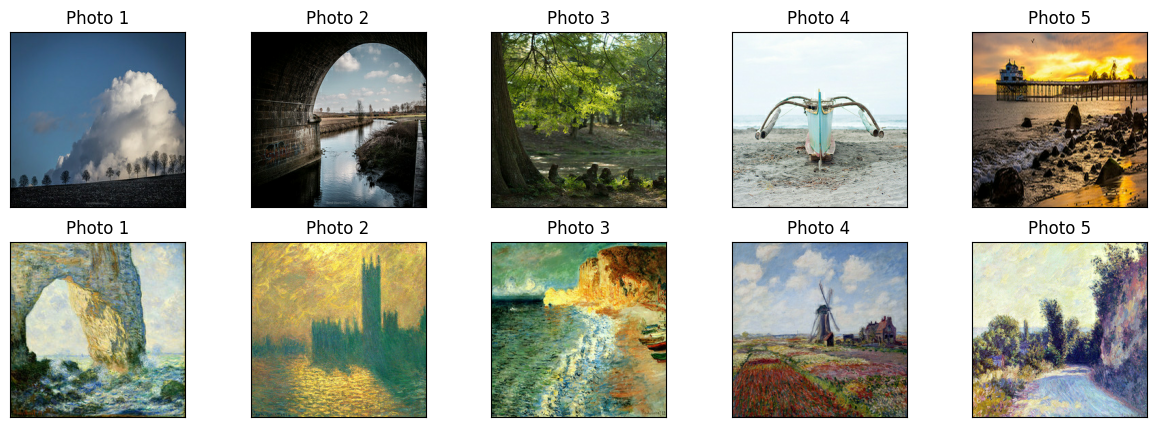

In [3]:
##Output number of files
print('Monet TFRecord Files: %d'%len(MONET_FILENAMES))
print('Photo TFRecord Files: %d'%len(PHOTO_FILENAMES))
print("Number of Monet images: %d"%len(os.listdir("/kaggle/input/gan-getting-started/monet_jpg")))
print("Number of Photo images: %d"%len(os.listdir("/kaggle/input/gan-getting-started/photo_jpg")))

##Print out samples of both photos and monet images
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

f = plt.figure(figsize=(15,5))
for idx,x in enumerate(iter(photo_ds)):
    example_photo = x[0]
    plt.subplot(2,5,idx+1)
    plt.title('Photo %d'%(idx+1))
    plt.imshow(example_photo * 0.5 + 0.5)
    plt.xticks([])
    plt.yticks([])
    if idx>=4:
        break

for idx,x in enumerate(iter(monet_ds)):
    example_photo = x[0]
    plt.subplot(2,5,idx+6)
    plt.title('Photo %d'%(idx+1))
    plt.imshow(example_photo * 0.5 + 0.5)
    plt.xticks([])
    plt.yticks([])
    if idx>=4:
        break

## Model Setup

The CycleGAN architecture consists of two generators and two discriminators.

Each of the generators is set up with an encoder that downsamples the emages repeatedly until it reaches an image embedding. The input images are same-padded and the convolutional layers use a stride of 2. Because of this, the image decreases by half in the X and Y dimensions on each downsample iteration. For this model, we use eight layers of downsampling to get to a 1x1x512 encoding for the image. 

Once encoded, the generator then mirrors the process using transpose convolutional layers, which perform the convolution in reverse, enlarging the image on each step. Once more eight upsamples leads back to a 256x256x3 final image.

In [4]:
##Create the functions to up/down sample images
def downsample(filters, size, apply_instancenorm=True, batchSize=1):
    #Initialize the 2D filter weights to ~N(0,.02), same for instance (group with axis=-1) normalization layer
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    #Create a 2D convolutional layer, instance normalization (as needed), and a leaky_relu
    result = keras.Sequential()
    result.add(keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(keras.layers.GroupNormalization(axis=-1,gamma_initializer=gamma_init))
    result.add(keras.layers.LeakyReLU())

    return result

#Downsample, but in reverse
def upsample(filters, size, apply_dropout=False):
    #Initialize weights to ~N(0,.02), same for instance (group with axis=-1) normalization layer
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    #Create the transpose convolutional layer to build new data, instance normalization, dropout (as needed) and a relu
    result = keras.Sequential()
    result.add(keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(keras.layers.GroupNormalization(axis=-1,gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(keras.layers.Dropout(0.5))
    result.add(keras.layers.ReLU())

    return result

Once the up and down sampling layers have been defined, it's time to arrange them in the model.

The generator, as noted before, consists of a stack of downsampling layers. Between them are 5 residual blocks, which are comprised of 3x3 convolutional layers that are same padded and use stride 1. This architecture differs from the original tutorial notebook in that it does not go down to a 1x1x512, but instead stays at 32x32xN and is passed through the aforementioned residual layers.

In [5]:
def Generator():
    #Define initialization
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = keras.layers.Input(shape=[256,256,3])

    #Create the stack of downsampling layers
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
    ]
    #Create the stack of upsampling layers
    up_stack = [
        upsample(512, 4), # (bs, 2, 2, 1024)
        upsample(512, 4), # (bs, 4, 4, 1024)
        upsample(512, 4), # (bs, 8, 8, 1024)
    ]
    #Define the output layer
    last = keras.layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)
    
    #Stitch the model together
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for idx in range(5):
        keras.layers.Conv2D(256,3)(x)

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = keras.layers.Concatenate()([x, skip])
    #Staple the output layer to the model
    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

The discriminators are much simpler in comparison. Images are downsampled to end up at 30x30 and evaluated against whether or not an image is a fake.

In [6]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = keras.layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp
    #Set up downsample stack
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    zero_pad1 = keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = keras.layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = keras.layers.Normalization()(conv)
    leaky_relu = keras.layers.LeakyReLU()(norm1)
    zero_pad2 = keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = keras.layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

Finally, the fully built model. When called, users must provide the aforementioned 2 generators and descriminators. When the model is compiled, users will also need to provide optimizers and loss functions.

The model itself needs further explanation and is poorly served only in text. On each cycle a few steps are made.

First an array of images are made.
* A photo is passed through the monet generator, and fed back through the photo generator to evaluate how well it can recreate the same image.
* The above step is applied to monet images.
* A Monet is fed to the Monet generator and a photo to the photo generator.

These generated and real photos are fed to the discriminators to get those results.

The discriminator results are then used to create losses for:
* Both discriminators
* Both generators
* Cycle consistancy loss. The loss of an image being put through one generator and back through the other.

These losses are backpropgated through the appropriate model and the cycle continues.

In [7]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Here we define the various losses used by the model. The discriminators use binary cross-entropy, as one would expect given the output is a logical defining a given image as true or false. The loss is aggregated for both the real and fake images into a total discriminator loss. The discriminator results are used to create then create the generator loss. The cycle consistancy loss is created by comparing the original image to the one that was passed through both generators and the identity loss is created from each generator being fed an image of that category.

The discriminator losses are averaged between the real and fake examples, the generator losses are taken directly, the cycle consistancy loss and identity loss are both mean absolute error.

Finally, an ADAM optimizer is used for each of the models. Once everything is defined, the final aggregate model is compiled and ready to train.

In [8]:
with strategy.scope():
    #Define the various losses for the model to use
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss
    #Specify the optimizer functions
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    #Initialize the generators/discriminators
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos
    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos
    #Build and compile the model
    cycle_gan_model = CycleGan(
            monet_generator, photo_generator, monet_discriminator, photo_discriminator
        )
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [9]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=100,
    verbose=1,
)

Epoch 1/100


I0000 00:00:1718989653.195676      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 144s 321ms/step - monet_disc_loss: 0.5704 - monet_gen_loss: 6.0902 - photo_disc_loss: 0.5346 - photo_gen_loss: 6.3461
Epoch 2/100


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 98s 326ms/step - monet_disc_loss: 0.5919 - monet_gen_loss: 4.1821 - photo_disc_loss: 0.6022 - photo_gen_loss: 4.1638
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 98s 326ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 3.8641 - photo_disc_loss: 0.5879 - photo_gen_loss: 4.0551
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 98s 325ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.9428 - photo_disc_loss: 0.5771 - photo_gen_loss: 4.1073
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 97s 323ms/step - monet_disc_loss: 0.5826 - monet_gen_loss: 3.9764 - photo_disc_loss: 0.5509 - photo_gen_loss: 4.1884
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 97s 324ms/step - monet_disc_loss: 0.5921 - monet_gen_loss: 3.8773 - photo_disc_loss: 0.5761 - photo_gen_loss: 4.0122
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 97s 324ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 3.5917 - photo_disc_loss: 0.5462 - photo_gen_loss: 3.9745
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 97s 324ms/step - monet_

## Conclusion

Below shows a sample output of Monet transferred images. The first image shows it somewhat working. The impressionistic style is there, but doesn't show up terribly well on images such as the drone. You can still tell that the images are softer and at least attempt to be impressionistic. An ok first attempt at style transfer.

Much of the ineffectiveness of teh model is likely due to using an older architecture that doesn't go down to a 1x1x512 feature layer and simply isn't as good as newer versions. Due to relying on the tutorial, I was hesitant to do so and reverted to implementing what I believe is an older version of CycleGAN. I also noticed the issue with square structures in the images that GANs sometimes make. I know there is a technique to address these, but I cannot locate it at this time. Researching that and implementing would also aid the model. There's also the argument of slowing down the learning rate on the discriminators as an experiment. Should they learn too quickly, then the model will stop learning.

In all, the model proves the possibility of using CycleGAN for style transfer, but doesn't quite succeed. Further iterations would be necessary to have the model working to the desired level.

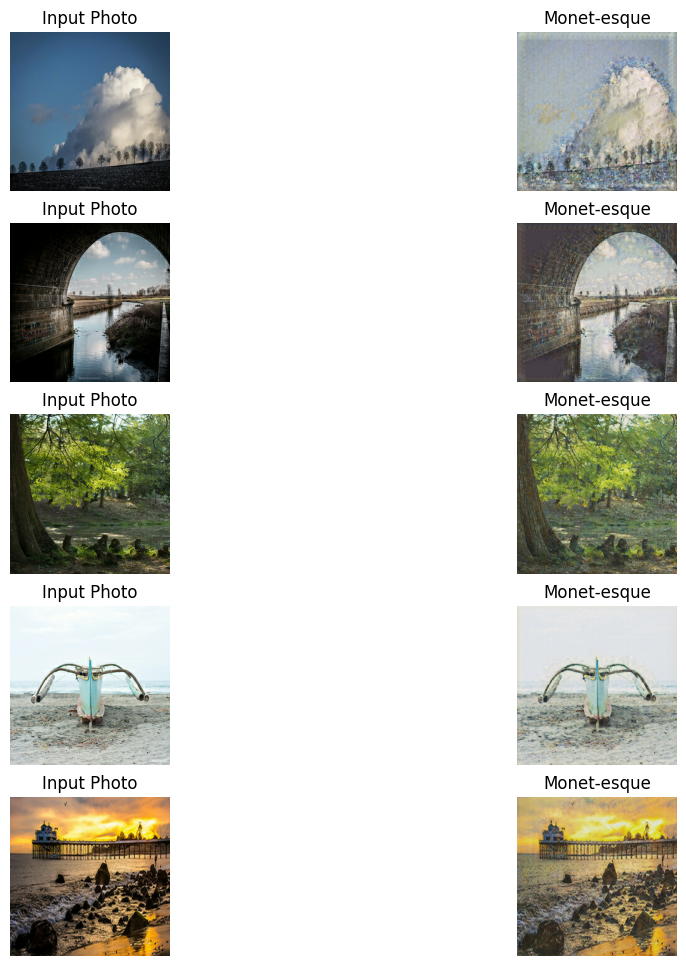

In [10]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [11]:
##Generate kaggle submission
savePath = "/kaggle/images/"
if not os.path.exists(savePath):
    os.mkdir(savePath)
for idx,img in enumerate(photo_ds.take(7000)):
    pred = monet_generator(img,training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    im = Image.fromarray(img)
    im.save(savePath+"p_%d.jpg"%idx)
shutil.make_archive("/kaggle/working/images",'zip',"/kaggle/images/")

'/kaggle/working/images.zip'